# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shap
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import StandardScaler, FunctionTransformer, label_binarize
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, auc, RocCurveDisplay,classification_report
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.ensemble import VotingClassifier, StackingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Baseline Model - Linear regression

## Unzip Files

### Unzip for Mousemovement data

In [3]:
# Define the zip file and destination folder
zip_path = r'data/interim/mousemovement_data.zip'  
extract_folder = "data/interim/mousemovement_data/"  

# Unzip the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Extracted to {extract_folder}")

Extracted to data/interim/mousemovement_data/


## Model

Separate the coordinates of mousemovement and pivot mousemove types

In [4]:
# Load the data
file_path = "data/interim/mousemovement_data/mousemovement_data.csv"
df = pd.read_csv(file_path)

# add another label to categorise into just human and bots
df['new_label'] = df['label'].apply(lambda x: 'bot' if x in ['moderate_bot', 'advanced_bot'] else 'human')

# Extract the mousemove_x and mousemove_y coordinates from the 'mousemove_behaviour' string column
df[['mousemove_x', 'mousemove_y']] = df['mousemove_behaviour'].str.replace(r'[()]', '', regex=True).str.split(',', expand=True)

# Convert mousemove_x and mousemove_y to integer type
df['mousemove_x'] = df['mousemove_x'].astype(int)
df['mousemove_y'] = df['mousemove_y'].astype(int)

# Convert mousemove_type to categorical type
df = pd.get_dummies(df, columns=['mousemove_type'], dtype=int)

df

,session_id,mousemove_times,mousemove_behaviour,label,new_label,mousemove_x,mousemove_y,mousemove_type_cl,mousemove_type_cm,mousemove_type_cr,mousemove_type_m
0,os9be9s5er1ud8569gm26htp0j,444694243,"(0,4)",moderate_bot,bot,0,4,0,0,0,1
1,os9be9s5er1ud8569gm26htp0j,444694260,"(0,5)",moderate_bot,bot,0,5,0,0,0,1
2,os9be9s5er1ud8569gm26htp0j,444694276,"(0,6)",moderate_bot,bot,0,6,0,0,0,1
3,os9be9s5er1ud8569gm26htp0j,444694293,"(0,7)",moderate_bot,bot,0,7,0,0,0,1
4,os9be9s5er1ud8569gm26htp0j,444694309,"(1,8)",moderate_bot,bot,1,8,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3640494,rh5fn2njcglhb2avkv30id017u,1595505964115,"(1082,94)",human,human,1082,94,0,0,0,1
3640495,rh5fn2njcglhb2avkv30id017u,1595505964132,"(1140,54)",human,human,1140,54,0,0,0,1
3640496,rh5fn2njcglhb2avkv30id017u,1595505964149,"(1182,26)",human,human,1182,26,0,0,0,1
3640497,rh5fn2njcglhb2avkv30id017u,1595505964166,"(1214,8)",human,human,1214,8,0,0,0,1


Train and evaluate model

In [5]:
# Select relevant columns for logistic classification
df_lc = df[['mousemove_x', 'mousemove_y', 'mousemove_type_cl', 'mousemove_type_cm', 'mousemove_type_cr', 'mousemove_type_m', 'new_label']]

# Features and target
X = df_lc.drop(columns='new_label')
y = df_lc['new_label']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit logistic regression model
clf = LogisticRegression(max_iter=1)
clf.fit(X_train, y_train)

# Predict class labels for test set
y_pred = clf.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Optional: Detailed metrics for evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Test Accuracy: 0.6812113720642768


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification Report:
               precision    recall  f1-score   support

         bot       0.68      1.00      0.81    495990
       human       0.00      0.00      0.00    232110

    accuracy                           0.68    728100
   macro avg       0.34      0.50      0.41    728100
weighted avg       0.46      0.68      0.55    728100

Confusion Matrix:
 [[495990      0]
 [232110      0]]


# load data for challenger models

In [6]:
# Load data
data = pd.read_csv('data/processed/data.csv')

X = data[[column for column in list(data.columns) if column not in ['label', 'session_id', 'new_label','entropy','acceleration_pos_neg_ratio','acceleration_std','clicks_count', 'durations','hover_frequency','speed_cv']]]
y = data[['new_label']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)



# PCA 
- explores the distribution of the three categories by reducing the high-dimensional data to two dimensions

### Without oversampling

Counter({'advanced_bot': 170, 'moderate_bot': 170, 'human': 109})


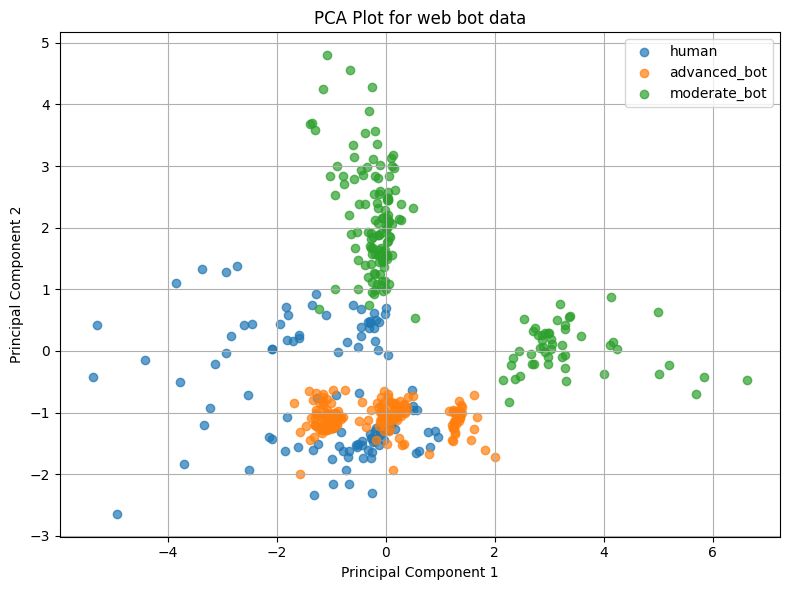

In [7]:
# Separate features and labels
X = data[[column for column in list(data.columns) if column not in ['label', 'session_id', 'new_label', 'entropy', 'acceleration_pos_neg_ratio','acceleration_std','clicks_count', 'durations','hover_frequency','speed_cv']]]
y = data['label']

def pca_plot(x,y):
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA to reduce to 2 components
    pca = PCA(n_components=2, svd_solver='full')
    principal_components = pca.fit_transform(X_scaled)

    # Create a new DataFrame for plotting
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['label'] = y

    # Plot
    plt.figure(figsize=(8, 6))
    for label in pca_df['label'].unique():
        subset = pca_df[pca_df['label'] == label]
        plt.scatter(subset['PC1'], subset['PC2'], label=f'{label}', alpha=0.7)

    plt.title('PCA Plot for web bot data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print(Counter(y))
pca_plot(X, y)

### SMOTE

Counter({'human': 170, 'advanced_bot': 170, 'moderate_bot': 170})


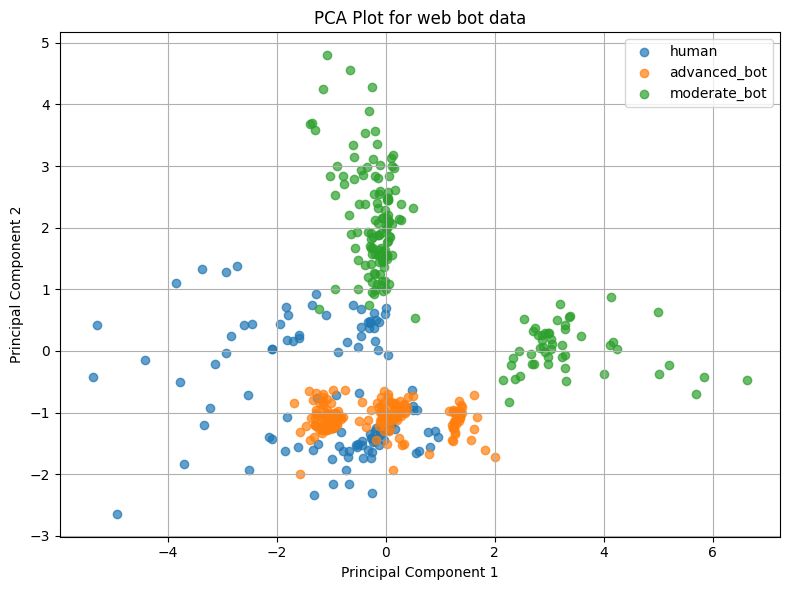

In [8]:
# Separate features and labels
X_smote = data[[column for column in list(data.columns) if column not in ['label', 'session_id', 'new_label', 'entropy', 'acceleration_pos_neg_ratio','acceleration_std','clicks_count', 'durations','hover_frequency','speed_cv']]]
y_smote = data['label']

oversample_smote = SMOTE(random_state=42)

X_smote, y_smote = oversample_smote.fit_resample(X_smote,y_smote)

print(Counter(y_smote))

pca_plot(X_smote,y_smote)

### Borderline SMOTE

Counter({'human': 170, 'advanced_bot': 170, 'moderate_bot': 170})


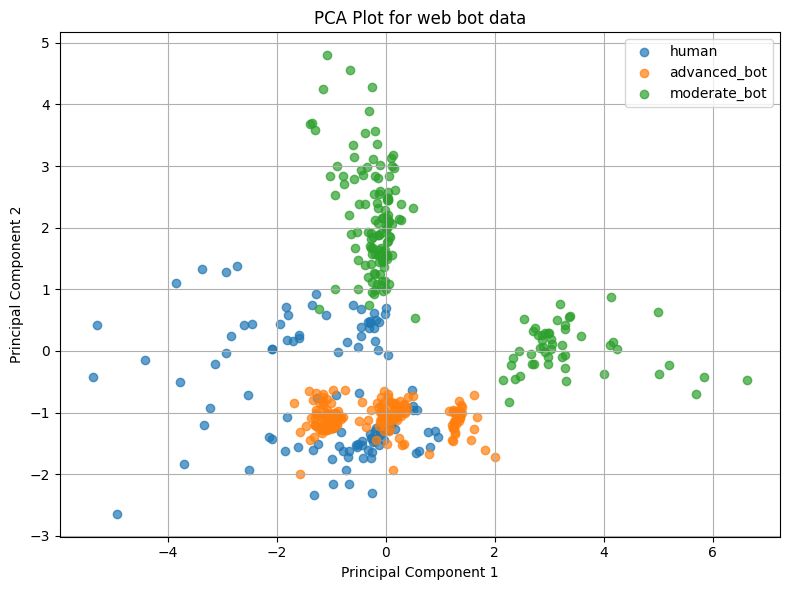

In [9]:
# Separate features and labels
X_bsmote = data[[column for column in list(data.columns) if column not in ['label', 'session_id', 'new_label', 'entropy', 'acceleration_pos_neg_ratio','acceleration_std','clicks_count', 'durations','hover_frequency','speed_cv']]]
y_bsmote = data['label']

# oversample = BorderlineSMOTE()
oversample_bsmote = BorderlineSMOTE(random_state=42)

X_bsmote,y_bsmote = oversample_bsmote.fit_resample(X,y)

print(Counter(y_bsmote))

pca_plot(X_bsmote, y_bsmote)

### ADASYN

Counter({'human': 170, 'advanced_bot': 170, 'moderate_bot': 170})


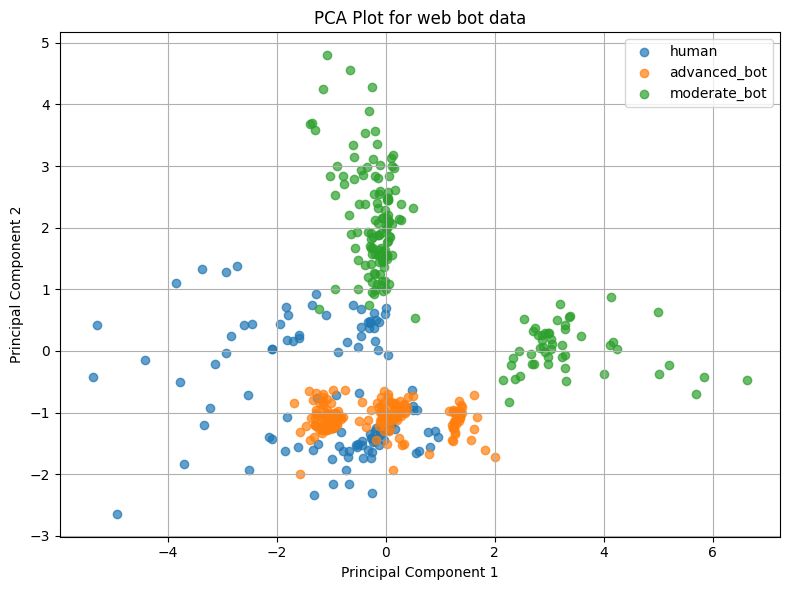

In [10]:
# Separate features and labels
X_ada = data[[column for column in list(data.columns) if column not in ['label', 'session_id', 'new_label', 'entropy', 'acceleration_pos_neg_ratio','acceleration_std','clicks_count', 'durations','hover_frequency','speed_cv']]]
y_ada = data['label']

oversample_ada = ADASYN(random_state=42)

X_ada, y_ada = oversample_ada.fit_resample(X_ada,y_ada)

print(Counter(y_smote))

pca_plot(X_smote,y_smote)

# Feature Selection

### Correlation matrix

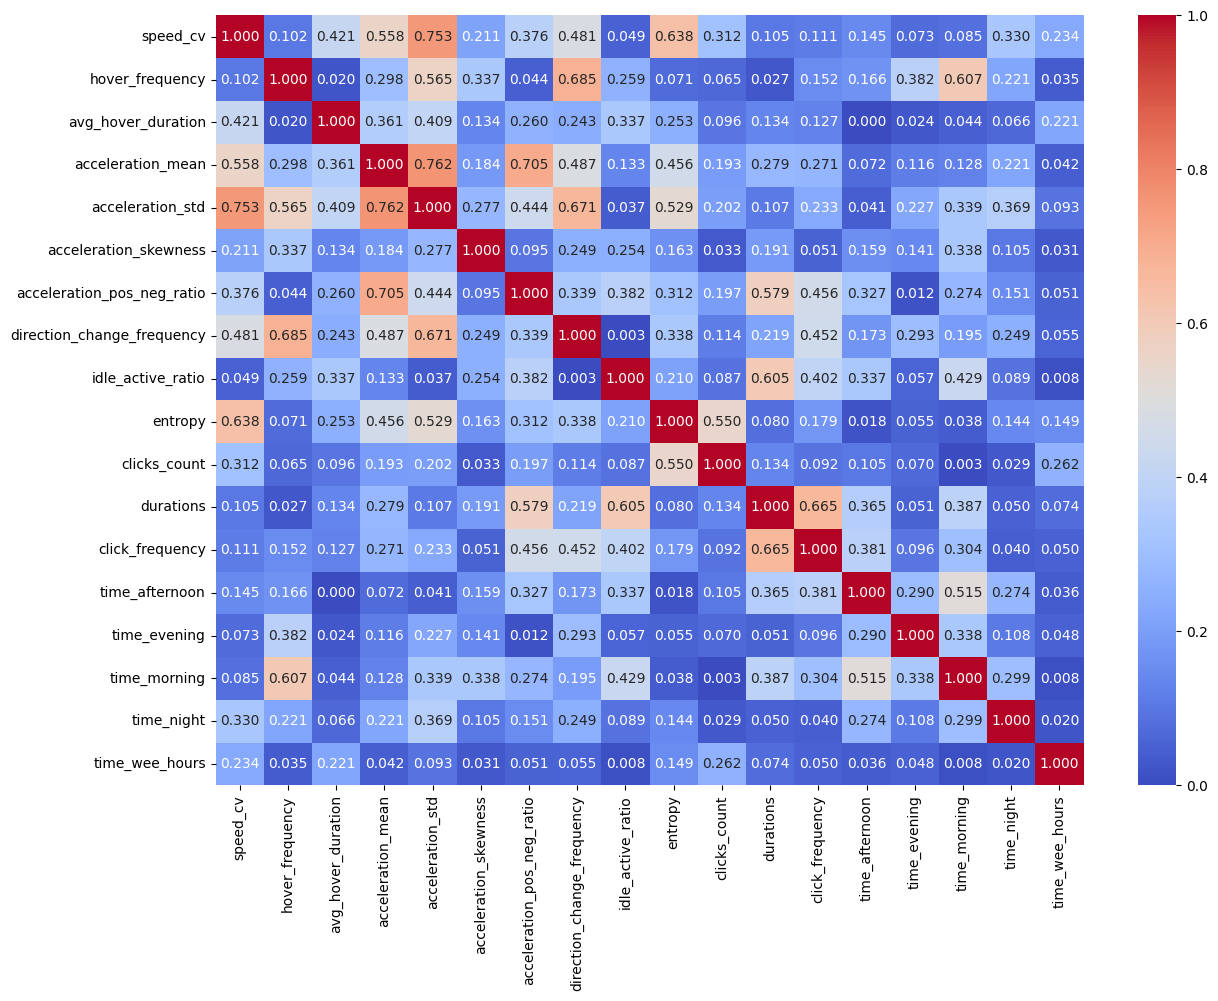

In [11]:
plt.figure(figsize=(14, 10))  # width=12 inches, height=8 inches

corr_matrix = data[[column for column in list(data.columns) if column != 'label' and column!= 'session_id' and column != 'new_label']].corr().abs()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', vmin=0, vmax=1)
plt.show()

In [12]:
corr_matrix

,speed_cv,hover_frequency,avg_hover_duration,acceleration_mean,acceleration_std,acceleration_skewness,acceleration_pos_neg_ratio,direction_change_frequency,idle_active_ratio,entropy,clicks_count,durations,click_frequency,time_afternoon,time_evening,time_morning,time_night,time_wee_hours
speed_cv,1.000000,0.101772,0.420776,0.557602,0.753249,0.211402,0.375829,0.481372,0.048963,0.637834,0.311904,0.104967,0.111313,0.144548,0.073485,0.084989,0.329502,0.234013
hover_frequency,0.101772,1.000000,0.019974,0.297946,0.564944,0.337223,0.043784,0.685158,0.259468,0.071085,0.064939,0.026820,0.152306,0.165849,0.382286,0.606821,0.221081,0.035156
avg_hover_duration,0.420776,0.019974,1.000000,0.361203,0.409313,0.133966,0.260404,0.242653,0.336894,0.252822,0.095598,0.134127,0.127018,0.000391,0.024293,0.043957,0.065804,0.221471
acceleration_mean,0.557602,0.297946,0.361203,1.000000,0.762054,0.184478,0.704776,0.487335,0.133208,0.456299,0.193439,0.278861,0.271394,0.071889,0.116325,0.128046,0.221383,0.041803
acceleration_std,0.753249,0.564944,0.409313,0.762054,1.000000,0.277299,0.444112,0.671025,0.036610,0.529238,0.201795,0.107206,0.232736,0.041240,0.226560,0.339179,0.369085,0.092553
acceleration_skewness,0.211402,0.337223,0.133966,0.184478,0.277299,1.000000,0.094952,0.248719,0.253712,0.162681,0.033346,0.190921,0.050824,0.158798,0.140650,0.337721,0.105255,0.030598
acceleration_pos_neg_ratio,0.375829,0.043784,0.260404,0.704776,0.444112,0.094952,1.000000,0.338601,0.381654,0.312224,0.196520,0.578798,0.455958,0.326674,0.012231,0.274286,0.150501,0.051042
direction_change_frequency,0.481372,0.685158,0.242653,0.487335,0.671025,0.248719,0.338601,1.000000,0.003114,0.338325,0.114100,0.218731,0.452353,0.172928,0.293193,0.194511,0.249459,0.055112
idle_active_ratio,0.048963,0.259468,0.336894,0.133208,0.036610,0.253712,0.381654,0.003114,1.000000,0.210286,0.086843,0.604582,0.402082,0.337306,0.056660,0.429270,0.089311,0.007832
entropy,0.637834,0.071085,0.252822,0.456299,0.529238,0.162681,0.312224,0.338325,0.210286,1.000000,0.550002,0.079682,0.178793,0.018052,0.054666,0.038363,0.144037,0.148760


In [13]:
# Compute absolute correlation matrix excluding 'label' and 'session_id'
corr_matrix = data[[col for col in data.columns if col not in ['label', 'session_id', 'new_label']]].corr().abs()

# Extract upper triangle of the correlation matrix without the diagonal
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find feature pairs with correlation greater than 0.4
high_corr = [
    (col1, col2, corr_matrix.loc[col1, col2])
    for col1 in corr_matrix.columns
    for col2 in corr_matrix.columns
    if col1 != col2 and corr_matrix.loc[col1, col2] > 0.4
]

# Remove duplicates like (A, B) and (B, A)
high_corr_unique = [
    (col1, col2, corr)
    for (col1, col2, corr) in high_corr
    if corr_matrix.columns.get_loc(col1) < corr_matrix.columns.get_loc(col2)
]

# View results
for var1, var2, corr_val in high_corr_unique:
    print(f"{var1} - {var2}: {corr_val:.2f}")

speed_cv - avg_hover_duration: 0.42
speed_cv - acceleration_mean: 0.56
speed_cv - acceleration_std: 0.75
speed_cv - direction_change_frequency: 0.48
speed_cv - entropy: 0.64
hover_frequency - acceleration_std: 0.56
hover_frequency - direction_change_frequency: 0.69
hover_frequency - time_morning: 0.61
avg_hover_duration - acceleration_std: 0.41
acceleration_mean - acceleration_std: 0.76
acceleration_mean - acceleration_pos_neg_ratio: 0.70
acceleration_mean - direction_change_frequency: 0.49
acceleration_mean - entropy: 0.46
acceleration_std - acceleration_pos_neg_ratio: 0.44
acceleration_std - direction_change_frequency: 0.67
acceleration_std - entropy: 0.53
acceleration_pos_neg_ratio - durations: 0.58
acceleration_pos_neg_ratio - click_frequency: 0.46
direction_change_frequency - click_frequency: 0.45
idle_active_ratio - durations: 0.60
idle_active_ratio - click_frequency: 0.40
idle_active_ratio - time_morning: 0.43
entropy - clicks_count: 0.55
durations - click_frequency: 0.67
time_a

### Variance Inflation Factor

Before removing features

In [14]:
feature_cols = [col for col in data.columns if col not in ['label', 'session_id', 'new_label']]
X = data[feature_cols]
vif_data = pd.DataFrame()
vif_data["feature"] = feature_cols
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["VIF"] = vif_data["VIF"].round(4)
print(vif_data)

                       feature      VIF
0                     speed_cv   8.7766
1              hover_frequency   8.0653
2           avg_hover_duration   1.7721
3            acceleration_mean   3.2188
4             acceleration_std  11.4337
5        acceleration_skewness   1.2752
6   acceleration_pos_neg_ratio  67.9432
7   direction_change_frequency   4.6034
8            idle_active_ratio   2.7952
9                      entropy   2.9055
10                clicks_count   1.9429
11                   durations  11.8668
12             click_frequency   2.3755
13              time_afternoon  13.8043
14                time_evening   6.6069
15                time_morning  15.0160
16                  time_night   5.4296
17              time_wee_hours   1.4020


After removing features

Features removed: 'entropy', 'acceleration_pos_neg_ratio','acceleration_std','clicks_count','durations','hover_frequency','speed_cv'

Features remaining: 'click_frequency', 'avg_hover_duration', 'acceleration_mean', 'acceleration_skewness', 'direction_change_frequency', 'idle_active_ratio', 'time_morning', 'time_afternoon', 'time_evening', 'time_night', 'time_wee_hours'

In [15]:
feature_cols = [col for col in data.columns if col not in ['label', 'session_id', 'new_label', 'entropy', 'acceleration_pos_neg_ratio','acceleration_std','clicks_count', 'durations','hover_frequency','speed_cv']]
X = data[feature_cols]
vif_data = pd.DataFrame()
vif_data["feature"] = feature_cols
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["VIF"] = vif_data["VIF"].round(4)
print(vif_data)

                       feature     VIF
0           avg_hover_duration  2.0669
1            acceleration_mean  2.7527
2        acceleration_skewness  1.3729
3   direction_change_frequency  2.8356
4            idle_active_ratio  2.9726
5              click_frequency  2.1432
6               time_afternoon  2.2551
7                 time_evening  1.3398
8                 time_morning  2.7009
9                   time_night  1.4263
10              time_wee_hours  1.0833


# Challenger Model 1 - K-Nearest Neighbours(KNN)

In [16]:
# Define k values to test
k_values = [3, 5, 7, 9]

## Training and testing models with cross validation

Resampling methods used
1. SMOTE
2. Borderline SMOTE
3. ADAYSN

### 1. SMOTE

In [64]:
# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_k = None
best_cv_score = 0.0

# Search for best k using cross-validation
for k in k_values:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('smote', SMOTE(sampling_strategy='minority', random_state=42)), 
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    print(f"k={k}: Mean CV Accuracy = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
    
    if mean_cv_score > best_cv_score:
        best_cv_score = mean_cv_score
        best_k = k

print(f"\nBest k: {best_k} with CV Accuracy = {best_cv_score:.4f}")

# Fit final model with best k on full training set
final_knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)), 
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

final_knn_pipe.fit(X_train, y_train)

# Predict on test set
y_pred = final_knn_pipe.predict(X_test)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]

# Evaluate test performance
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)


print(f"\nTest set accuracy (best k={best_k}): {test_accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(final_knn_pipe.named_steps['knn'].classes_)

k=3: Mean CV Accuracy = 0.9628 ± 0.0310
k=5: Mean CV Accuracy = 0.9704 ± 0.0251
k=7: Mean CV Accuracy = 0.9481 ± 0.0459
k=9: Mean CV Accuracy = 0.9444 ± 0.0422

Best k: 5 with CV Accuracy = 0.9704

Test set accuracy (best k=5): 0.9667
ROC AUC: 0.9703
['bot' 'human']


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Confusion Matrix

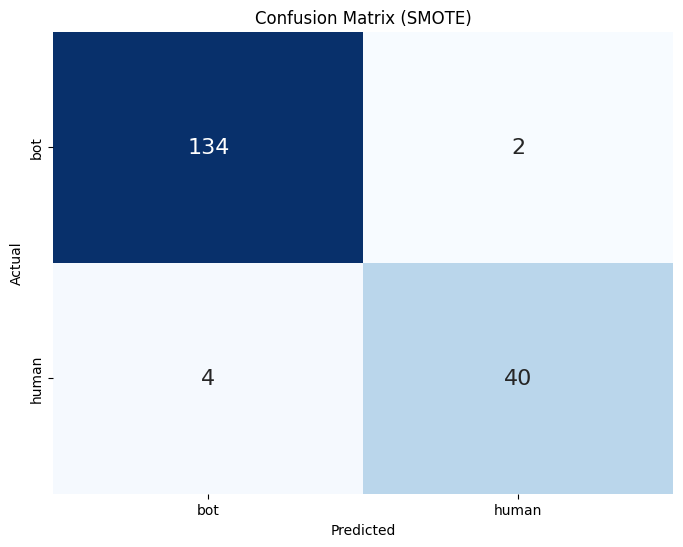

In [18]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SMOTE)')
plt.show()

F1 Score

In [19]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9667


ROC AUC

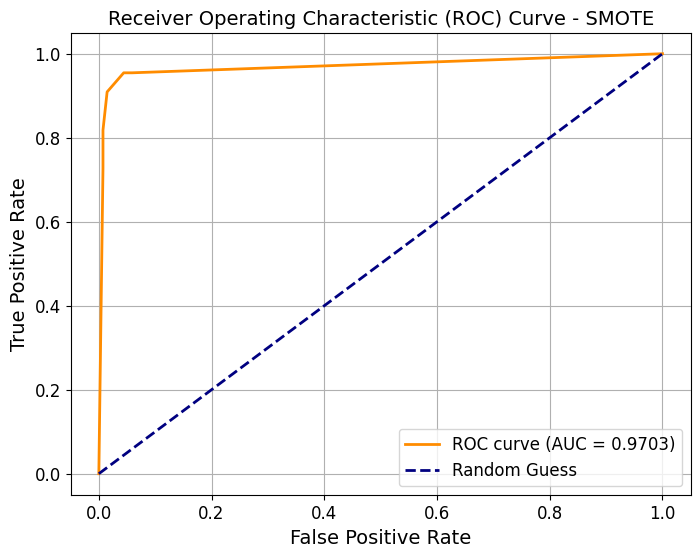

In [20]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - SMOTE', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

### 2. Borderline SMOTE

In [63]:
# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_k = None
best_cv_score = 0.0

# Search for best k using cross-validation
for k in k_values:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('smote', BorderlineSMOTE(sampling_strategy='minority', random_state=42)), 
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    print(f"k={k}: Mean CV Accuracy = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
    
    if mean_cv_score > best_cv_score:
        best_cv_score = mean_cv_score
        best_k = k

print(f"\nBest k: {best_k} with CV Accuracy = {best_cv_score:.4f}")

# Fit final model with best k on full training set
final_knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('smote', BorderlineSMOTE(sampling_strategy='minority', random_state=42)), 
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

final_knn_pipe.fit(X_train, y_train)

# Predict on test set
y_pred = final_knn_pipe.predict(X_test)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]

# Evaluate test performance
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\nTest set accuracy (best k={best_k}): {test_accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(final_knn_pipe.named_steps['knn'].classes_)

k=3: Mean CV Accuracy = 0.9516 ± 0.0363
k=5: Mean CV Accuracy = 0.9405 ± 0.0378
k=7: Mean CV Accuracy = 0.9294 ± 0.0488
k=9: Mean CV Accuracy = 0.9256 ± 0.0424

Best k: 3 with CV Accuracy = 0.9516

Test set accuracy (best k=3): 0.9611
ROC AUC: 0.9709
['bot' 'human']


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Confusion Matrix

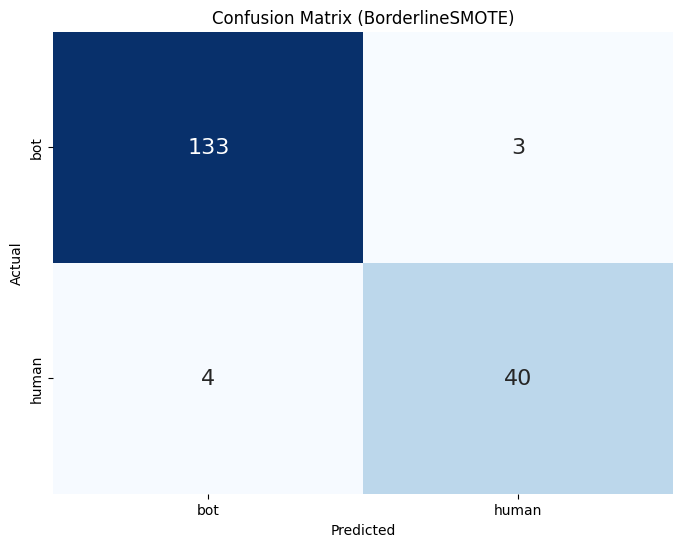

In [22]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (BorderlineSMOTE)')
plt.show()

F1 Score

In [23]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9611


ROC AUC

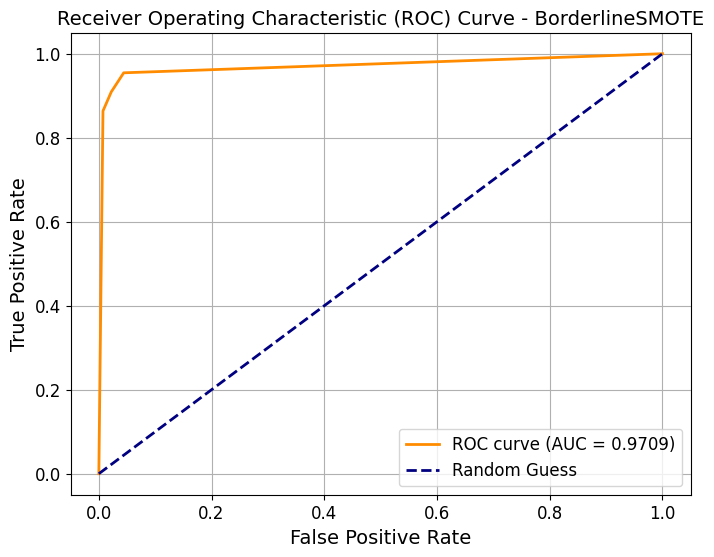

In [24]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - BorderlineSMOTE', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

### 3. ADASYN

In [25]:
# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_k = None
best_cv_score = 0.0

# Search for best k using cross-validation
for k in k_values:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('smote', ADASYN(sampling_strategy='minority', random_state=42)), 
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    print(f"k={k}: Mean CV Accuracy = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
    
    if mean_cv_score > best_cv_score:
        best_cv_score = mean_cv_score
        best_k = k

print(f"\nBest k: {best_k} with CV Accuracy = {best_cv_score:.4f}")

# Fit final model with best k on full training set
final_knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('smote', ADASYN(sampling_strategy='minority', random_state=42)), 
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

final_knn_pipe.fit(X_train, y_train)

# Predict on test set
y_pred = final_knn_pipe.predict(X_test)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]

# Evaluate test performance
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\nTest set accuracy (best k={best_k}): {test_accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(final_knn_pipe.named_steps['knn'].classes_)

k=3: Mean CV Accuracy = 0.9479 ± 0.0429
k=5: Mean CV Accuracy = 0.9442 ± 0.0422
k=7: Mean CV Accuracy = 0.9368 ± 0.0477
k=9: Mean CV Accuracy = 0.9331 ± 0.0477

Best k: 3 with CV Accuracy = 0.9479

Test set accuracy (best k=3): 0.9611
ROC AUC: 0.9711
['bot' 'human']


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Confusion Matrix

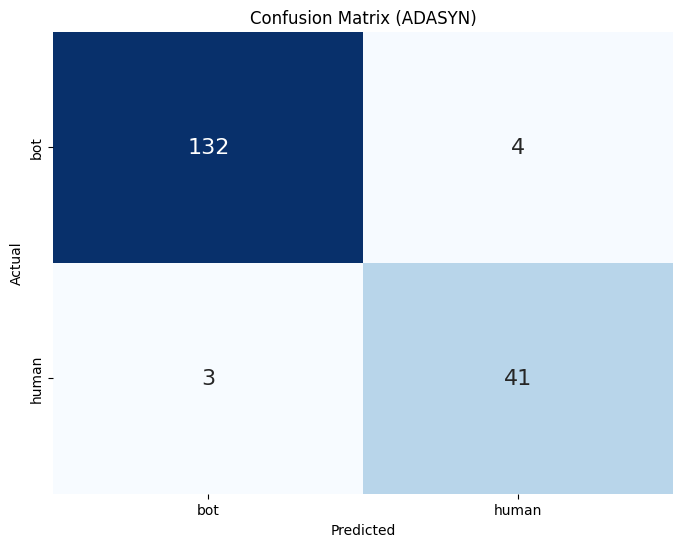

In [26]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (ADASYN)')
plt.show()

F1 Score

In [27]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9611


ROC AUC

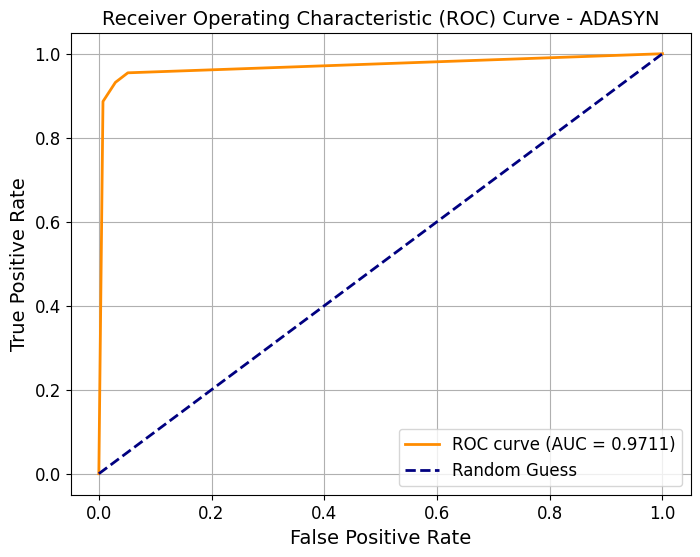

In [28]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = final_knn_pipe.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - ADASYN', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

# Challenger Model 2 - Decision Tree

## Training and testing models with cross validation

Resampling methods used
1. SMOTE
2. Borderline SMOTE
3. ADAYSN

### 1. SMOTE

In [29]:
#  Setup K-Fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline: SMOTE + Decision Tree
tree_pipe = Pipeline([
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

#  Cross-validate on training set only
cv_scores = cross_val_score(tree_pipe, X_train, y_train, cv=kfold, scoring='accuracy')

print(f"Cross-validated Accuracy = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train final model on the FULL training set
tree_pipe.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = tree_pipe.predict(X_test)

#  Evaluate on the test set
test_accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"\nTest set Accuracy (Decision Tree + SMOTE): {test_accuracy_tree:.4f}")

Cross-validated Accuracy = 0.9852 ± 0.0216

Test set Accuracy (Decision Tree + SMOTE): 0.9889


Confusion Matrix

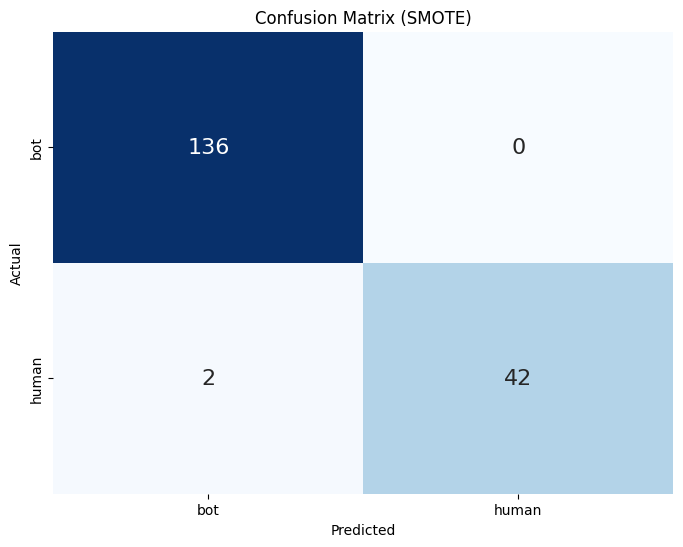

In [30]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SMOTE)')
plt.show()

F1 Score

In [31]:
f1 = f1_score(y_test, y_pred_tree, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9889


ROC AUC

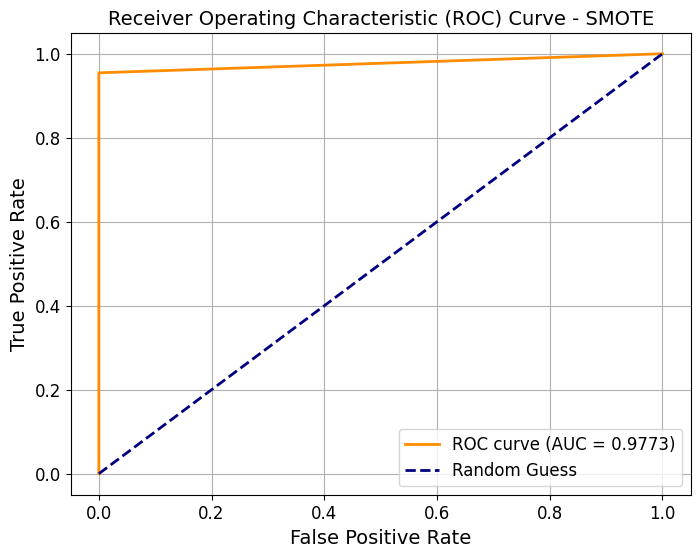

In [32]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = tree_pipe.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - SMOTE', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

### 2. Borderline SMOTE

In [33]:
tree_pipe_borderline = Pipeline([
    ('borderline_smote', BorderlineSMOTE(sampling_strategy='minority', random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

cv_scores_borderline = cross_val_score(tree_pipe_borderline, X_train, y_train, cv=kfold, scoring='accuracy')
print(f"Cross-validated Accuracy (Borderline-SMOTE) = {np.mean(cv_scores_borderline):.4f} ± {np.std(cv_scores_borderline):.4f}")


# Train final model on full training set
tree_pipe_borderline.fit(X_train, y_train)

#  Predict on test set
y_pred_tree_borderline = tree_pipe_borderline.predict(X_test)

# Evaluate
test_accuracy_tree_borderline = accuracy_score(y_test, y_pred_tree_borderline)
print(f"\nTest set Accuracy (Decision Tree + Borderline-SMOTE): {test_accuracy_tree_borderline:.4f}")


Cross-validated Accuracy (Borderline-SMOTE) = 0.9815 ± 0.0166

Test set Accuracy (Decision Tree + Borderline-SMOTE): 1.0000


Confusion Matrix

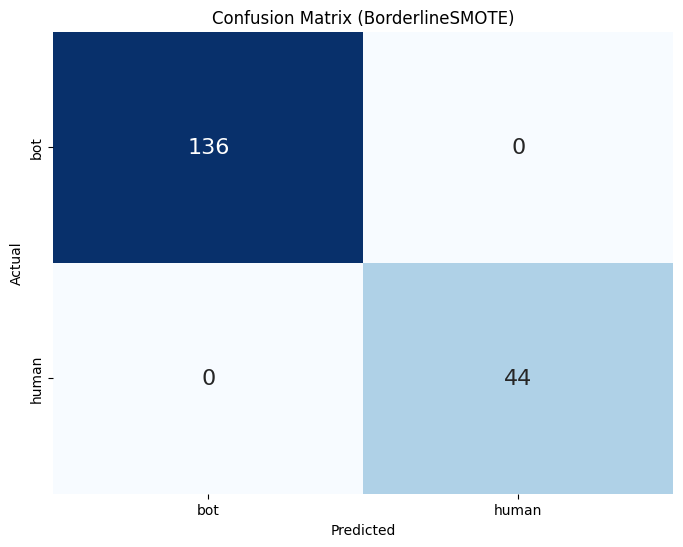

In [34]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree_borderline)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (BorderlineSMOTE)')
plt.show()

F1 Score

In [35]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred_tree_borderline, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 1.0000


ROC AUC

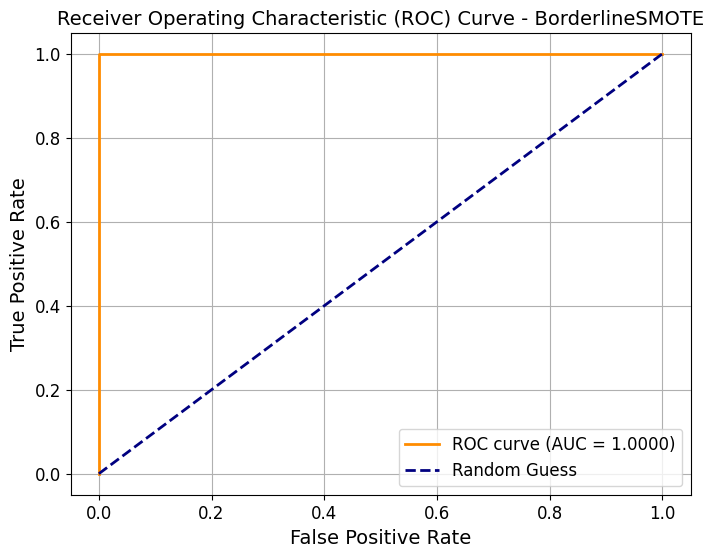

In [36]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = tree_pipe_borderline.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - BorderlineSMOTE', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

### 3. ADASYN

In [37]:
tree_pipe_adasyn = Pipeline([
    ('adasyn', ADASYN(sampling_strategy='minority', random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Cross-validate on training set
cv_scores_adasyn = cross_val_score(tree_pipe_adasyn, X_train, y_train, cv=kfold, scoring='accuracy')
print(f"Cross-validated Accuracy (ADASYN) = {np.mean(cv_scores_adasyn):.4f} ± {np.std(cv_scores_adasyn):.4f}")


# Train final model on full training set
tree_pipe_adasyn.fit(X_train, y_train)

# Predict on test set
y_pred_tree_adasyn = tree_pipe_adasyn.predict(X_test)

# Evaluate
test_accuracy_tree_adasyn = accuracy_score(y_test, y_pred_tree_adasyn)
print(f"\nTest set Accuracy (Decision Tree + ADASYN): {test_accuracy_tree_adasyn:.4f}")

Cross-validated Accuracy (ADASYN) = 0.9815 ± 0.0234

Test set Accuracy (Decision Tree + ADASYN): 0.9944


Confusion Matrix

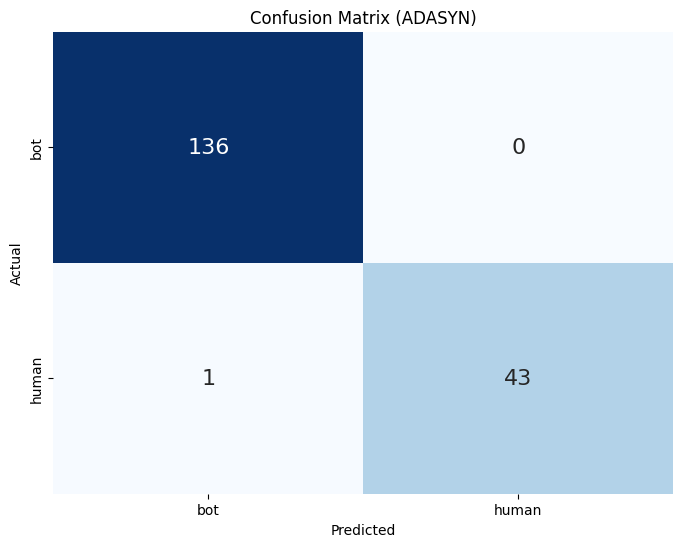

In [38]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree_adasyn)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (ADASYN)')
plt.show()

F1 Score

In [39]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred_tree_adasyn, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9944


ROC AUC

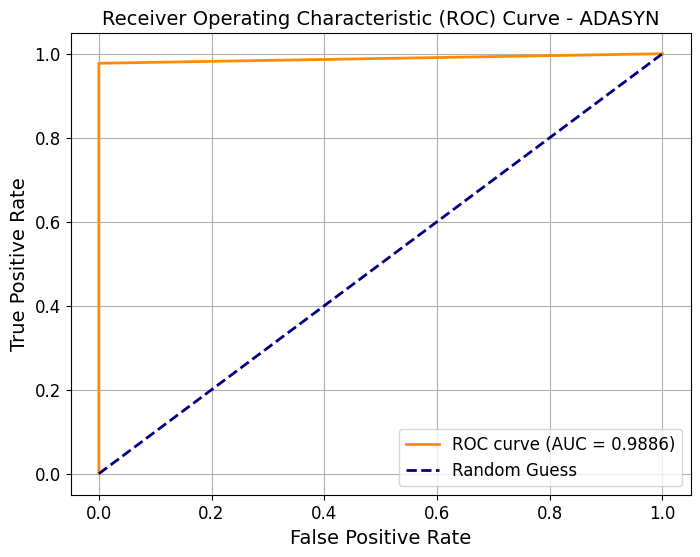

In [40]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = tree_pipe_adasyn.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - ADASYN', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

# Model Ensemble
1. Voting Classifier
2. Stacking Method & SHAP

In [65]:
feature_names = [column for column in list(data.columns) 
          if column not in ['label', 'session_id', 'new_label','entropy',
                            'acceleration_pos_neg_ratio','acceleration_std',
                            'clicks_count', 'durations','hover_frequency','speed_cv']]

## 1. Model Ensemble: Voting Classifier

In [66]:
# DEFINE BEST DECISION TREE PIPELINE (ADASYN) 
tree_pipe_adasyn = Pipeline([
    ('adasyn', ADASYN(sampling_strategy='minority', random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

In [67]:
# Train on full training set
tree_pipe_adasyn.fit(X_train, y_train)

Pipeline(steps=[('adasyn',
                 ADASYN(random_state=42, sampling_strategy='minority')),
                ('tree',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [68]:
# -DEFINE BEST KNN PIPELINE (SMOTE) 

best_k = 5  

knn_pipe_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

In [69]:
# Train on full training set
knn_pipe_smote.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('knn', KNeighborsClassifier())])

In [70]:
#  BUILD FINAL VOTING ENSEMBLE 
ensemble_model = VotingClassifier(
    estimators=[
        ('decision_tree_adasyn', tree_pipe_adasyn),
        ('knn_smote', knn_pipe_smote)
    ],
    voting='soft'  # Soft voting to use predicted probabilities
)

In [71]:
# Train ensemble
ensemble_model.fit(X_train, y_train)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


VotingClassifier(estimators=[('decision_tree_adasyn',
                              Pipeline(steps=[('adasyn',
                                               ADASYN(random_state=42,
                                                      sampling_strategy='minority')),
                                              ('tree',
                                               DecisionTreeClassifier(class_weight='balanced',
                                                                      random_state=42))])),
                             ('knn_smote',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('smote',
                                               SMOTE(random_state=42,
                                                     sampling_strategy='minority')),
                                              ('knn',
                                               KNeighborsClassifier())]))],
                 voting='soft')

In [72]:
# PREDICT AND EVALUATE ENSEMBLE 
y_pred_ensemble = ensemble_model.predict(X_test)
y_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

# Evaluate ensemble performance
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='weighted')
ensemble_roc_auc = roc_auc_score(y_test, y_prob_ensemble)

print(f"Voting Test Accuracy: {ensemble_accuracy:.4f}")
print(f"Voting F1-Score (Weighted): {ensemble_f1:.4f}")
print(f"Voting ROC AUC: {ensemble_roc_auc:.4f}")


Voting Test Accuracy: 0.9833
Voting F1-Score (Weighted): 0.9831
Voting ROC AUC: 0.9997


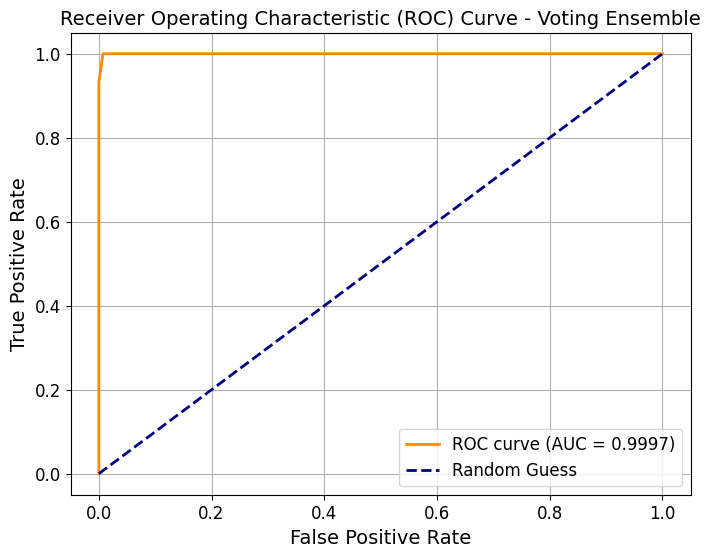

In [73]:

roc_auc = roc_auc_score(y_test, y_prob_ensemble)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_ensemble, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Voting Ensemble', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

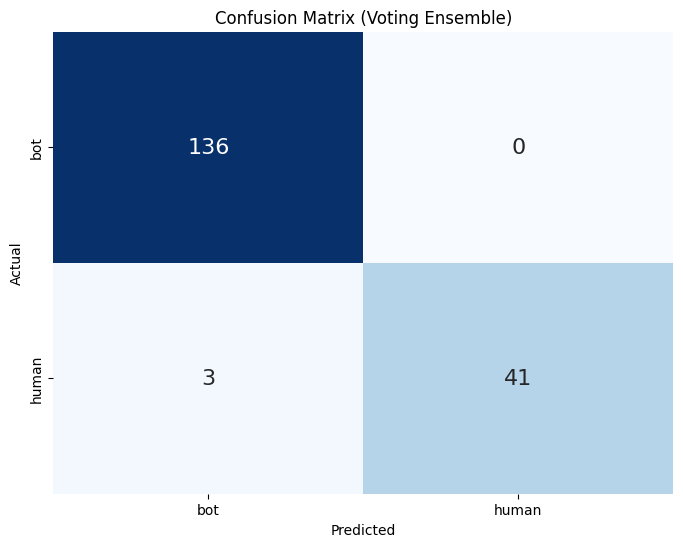

In [74]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Voting Ensemble)')
plt.show()

## 2. Stacking Method & SHAP (SHapley Additive exPlanations)

This increases explanability of the model.

Train each model type separately, then use a meta-model to make predictions.

In [75]:

# Best k value for KNN
best_k = 5

# Pipelines with resampling
# Decision Tree pipeline with ADASYN
tree_pipe_adasyn = Pipeline([
    ('adasyn', ADASYN(sampling_strategy='minority', random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# KNN pipeline with BorderlineSMOTE
knn_pipe_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

# Meta-model
meta_model = LogisticRegression()

# Stacking ensemble
stacking_clf = StackingClassifier(
    estimators=[
        ('decision_tree', tree_pipe_adasyn),
        ('knn', knn_pipe_smote)
    ],
    final_estimator=meta_model,
    cv=5,
    stack_method='predict_proba'
)

# Fit model
stacking_clf.fit(X_train, y_train)

# Predict
y_pred = stacking_clf.predict(X_test)
y_prob = stacking_clf.predict_proba(X_test)[:, 1]

# Get scores
stacking_accuracy = accuracy_score(y_test, y_pred)
stacking_f1 = f1_score(y_test, y_pred, average='weighted')
stacking_roc_auc = roc_auc_score(y_test, y_prob)

print(f"Stacking Test Accuracy: {stacking_accuracy:.4f}")
print(f"Stacking F1-Score (Weighted): {stacking_f1:.4f}")
print(f"Stacking ROC AUC: {stacking_roc_auc:.4f}")


Stacking Test Accuracy: 0.9944
Stacking F1-Score (Weighted): 0.9945
Stacking ROC AUC: 0.9999


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


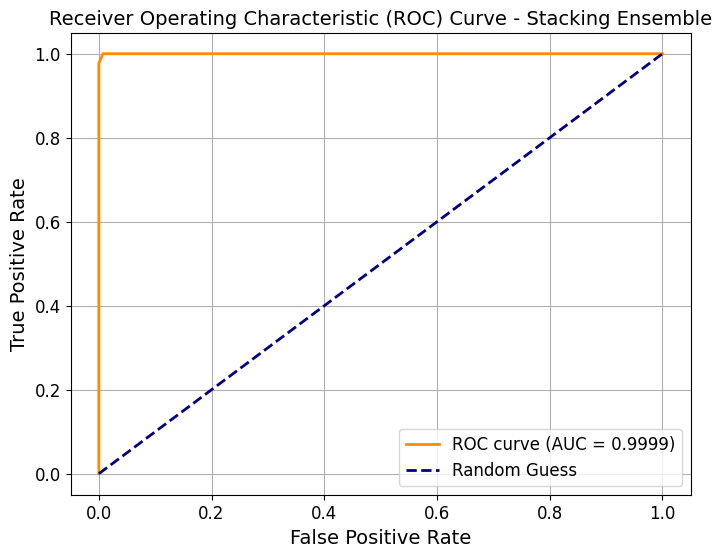

In [76]:

roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Stacking Ensemble', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

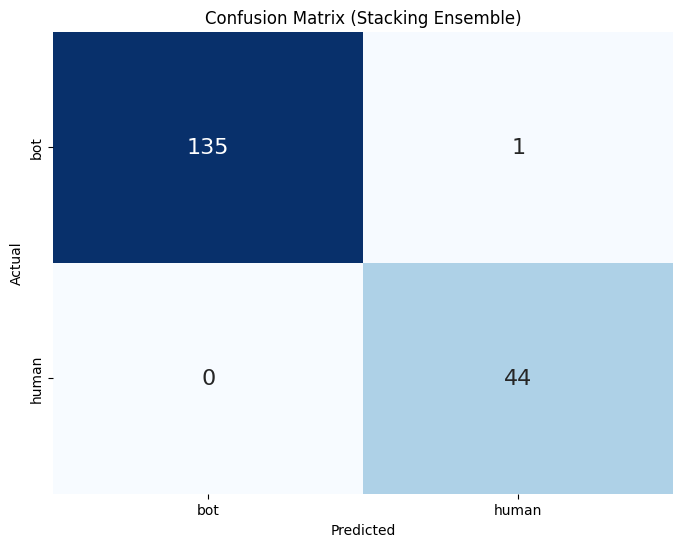

In [77]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Stacking Ensemble)')
plt.show()

In [78]:
# --- Interpretability ---

# Fit base pipelines separately for interpretation
tree_pipe_adasyn.fit(X_train, y_train)
knn_pipe_smote.fit(X_train, y_train)

# Decision Tree rules
print("\n--- Decision Tree Rules ---")
tree = tree_pipe_adasyn.named_steps['tree']
tree_rules = export_text(tree, feature_names=feature_names)
print(tree_rules)


--- Decision Tree Rules ---
|--- avg_hover_duration <= 3143.87
|   |--- idle_active_ratio <= 0.64
|   |   |--- avg_hover_duration <= 586.49
|   |   |   |--- class: bot
|   |   |--- avg_hover_duration >  586.49
|   |   |   |--- class: human
|   |--- idle_active_ratio >  0.64
|   |   |--- acceleration_mean <= -45.01
|   |   |   |--- direction_change_frequency <= 0.41
|   |   |   |   |--- class: bot
|   |   |   |--- direction_change_frequency >  0.41
|   |   |   |   |--- avg_hover_duration <= 735.54
|   |   |   |   |   |--- class: bot
|   |   |   |   |--- avg_hover_duration >  735.54
|   |   |   |   |   |--- class: human
|   |   |--- acceleration_mean >  -45.01
|   |   |   |--- class: bot
|--- avg_hover_duration >  3143.87
|   |--- direction_change_frequency <= 0.40
|   |   |--- class: bot
|   |--- direction_change_frequency >  0.40
|   |   |--- class: human



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Show the 5 nearest neighbours for the first test sample

In [79]:
# KNN Nearest Neighbors for a sample
print("\n--- KNN Nearest Neighbors (for first test sample) ---")
knn = knn_pipe_smote.named_steps['knn']

# Ensure that the input to kneighbors is 2D
distances, indices = knn.kneighbors(X_test.iloc[[0]].values.reshape(1, -1))  # Use iloc and pass as 2D

print("Distances:", distances)
print("Neighbor indices:", indices)
print("Neighbor labels:", y_train.iloc[knn._y[indices.flatten()]].values)



--- KNN Nearest Neighbors (for first test sample) ---
Distances: [[1200.86075965 1201.68007796 1201.95948674 1202.13315032 1202.5654542 ]]
Neighbor indices: [[ 61 326  76 324 278]]
Neighbor labels: [['human']
 ['human']
 ['human']
 ['human']
 ['human']]


In [80]:
# Logistic Regression coefficients (meta-model)
print("\n--- Meta-model (Logistic Regression) Coefficients ---")
meta_model.fit(X_train, y_train)
for name, coef in zip(feature_names, meta_model.coef_[0]):
    print(f"{name}: {coef:.3f}")


--- Meta-model (Logistic Regression) Coefficients ---
avg_hover_duration: 0.000
acceleration_mean: -0.000
acceleration_skewness: -0.000
direction_change_frequency: -0.000
idle_active_ratio: -0.000
click_frequency: -0.000
time_afternoon: -0.000
time_evening: -0.000
time_morning: 0.000
time_night: 0.000
time_wee_hours: 0.000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


#### SHAP Values Calculation

We then make use of SHAP values to understand how each feature contributes to a particular prediction in the model ensemble.

In [81]:
# SHAP interpretation for the stacking model
print("\n--- SHAP Interpretation ---")
explainer = shap.Explainer(stacking_clf.predict_proba, X_train)
shap_values = explainer(X_test)


--- SHAP Interpretation ---


PermutationExplainer explainer: 181it [00:22,  4.44it/s]                         


Draw summary plot for bot class

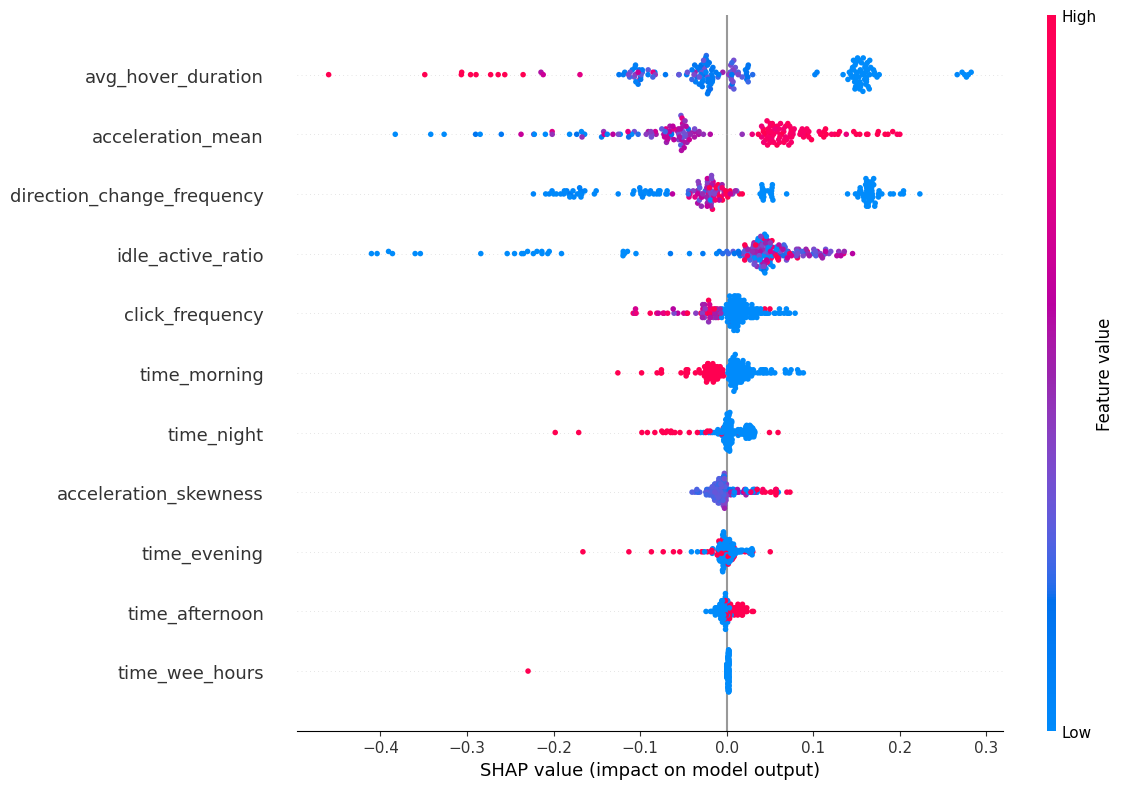

In [82]:

# Visualize SHAP summary plot
shap.initjs()
# Plot the SHAP summary plot with customized figure size and font size

shap.summary_plot(shap_values[...,0], X_test, plot_size=(12, 8))



Draw summary plot for human class

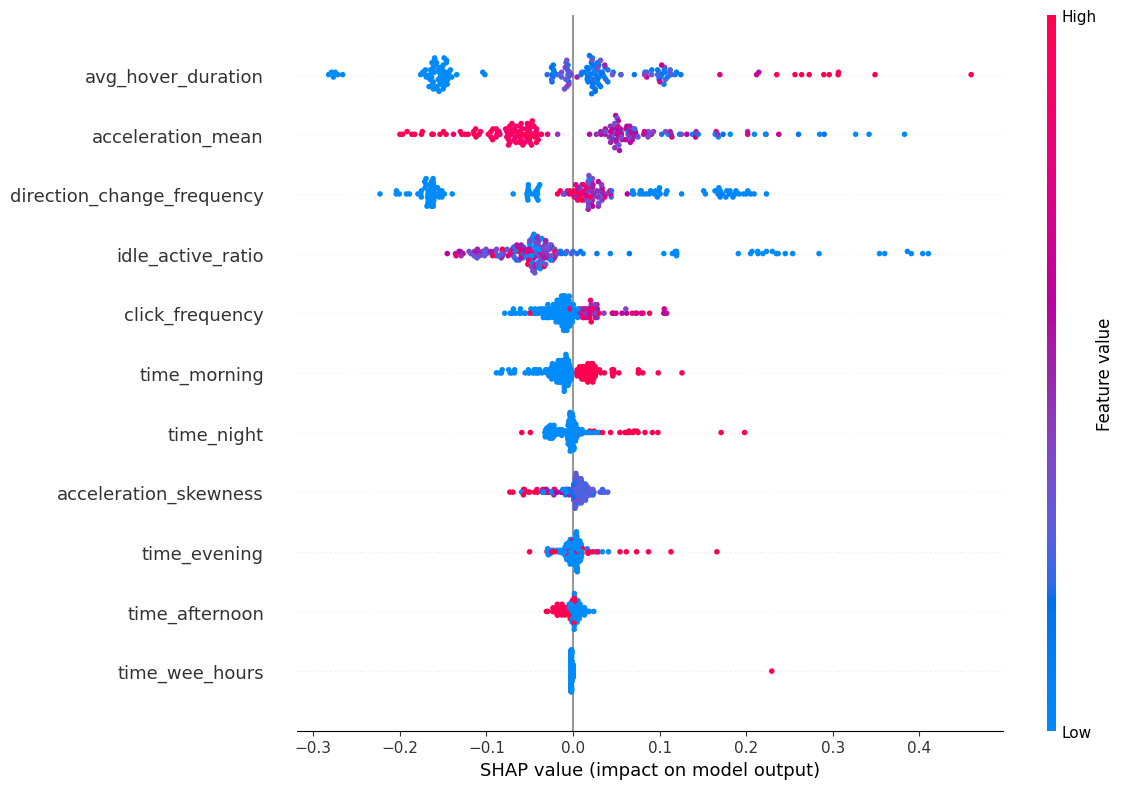

In [83]:
# Visualize SHAP summary plot
shap.initjs()
# Plot the SHAP summary plot with customized figure size and font size

shap.summary_plot(shap_values[...,1], X_test, plot_size=(12, 8))

##### SHAP values for one test session

The further left a bar is, the less indicative the feature is for the session to be human.

The further right a bar is, the more indicative the feature is for the session to be human.


Explanation:

E(f(x)): The baseline prediction across all data points in the training dataset, before any features are taken into account for for the particular session being predicted on.

f(x): the model's predicted output for the input x, in this case whether session x is human or bot, after taking into account all the features for x.


f(x) = E(f(x)) + (sum of every feature's SHAP value)

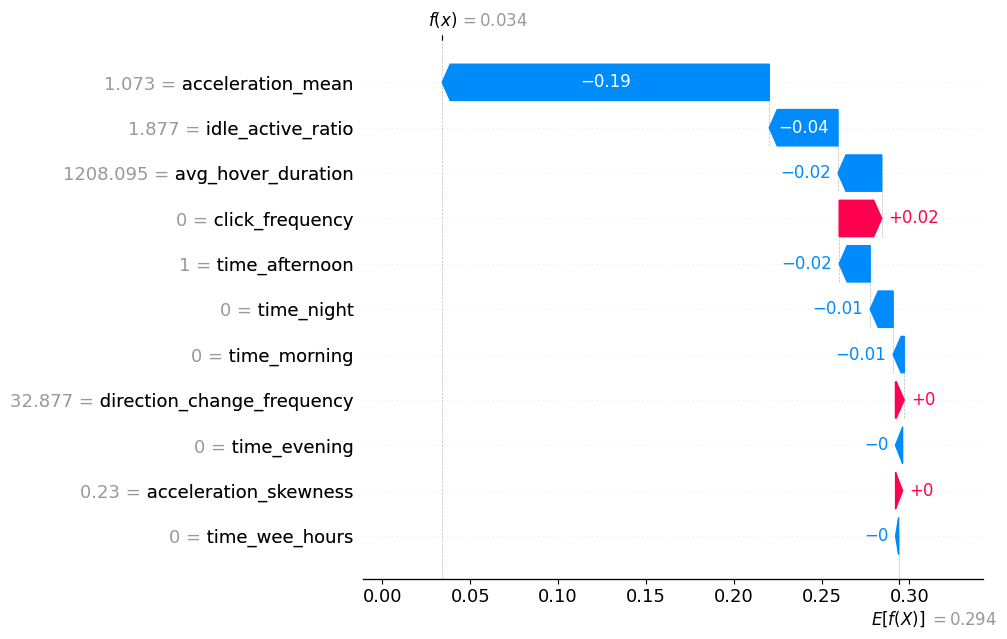

In [84]:
# Extract SHAP values for the second class (class 1)
shap_values_for_class_1 = shap_values[:, :, 1]  # Get SHAP values for class 1 (human)


# Visualize SHAP waterfall plot for the first test sample
shap.plots.waterfall(shap.Explanation(values=shap_values_for_class_1[0], 
                                      base_values=shap_values.base_values[0], 
                                      data=X_test.iloc[0], 
                                      feature_names=feature_names),
                                      max_display=len(feature_names))



##### SHAP Values for the bot class

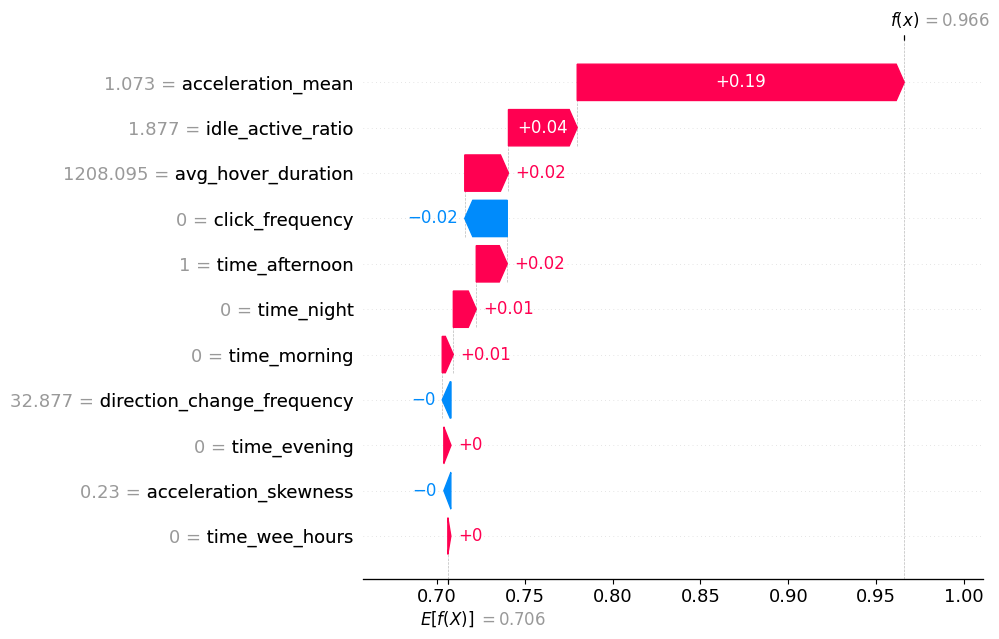

In [85]:
# Extract SHAP values for the first class (class 0)
shap_values_for_class_0 = shap_values[:, :, 0]  # Get SHAP values for class 0 (bot)


# Visualize SHAP waterfall plot for the first test sample
shap.plots.waterfall(shap.Explanation(values=shap_values_for_class_0[0], 
                                      base_values=shap_values.base_values[0], 
                                      data=X_test.iloc[0], 
                                      feature_names=feature_names),
                                      max_display=len(feature_names))